# Mining Unexpected Concepts
---
Wikivitals

**Libraries**

In [1]:
from collections import defaultdict, Counter
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.clustering import get_modularity, KMeans, Louvain
from sknetwork.data import load_netset, from_edge_list
from sknetwork.embedding import Spectral, SVD
from sknetwork.gnn import GNNClassifier
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques, get_connected_components
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.utils.kmeans import KMeansDense
from sknetwork.utils.check import get_probs
from sknetwork.visualization import svg_graph

## Data

In [81]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [82]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [83]:
biadjacency

<10011x37845 sparse matrix of type '<class 'numpy.int64'>'
	with 1363301 stored elements in Compressed Sparse Row format>

In [4]:
names

array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
      dtype='<U62')

In [5]:
words[:10]

array(['Alexis', 'Cairo', 'subordinate', 'marching', 'bengali', 'Adal',
       'pulvinus', 'Gallia', 'Harris', 'Toshiro'], dtype='<U26')

## Algorithm

In [6]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    return (nodes_mdl + edges_mdl)

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

In [7]:
def in_close(adjacency, context, extents, intents, unexs, unexs_g, r, y, degs, gain, verbose):
    
    support_obj = 5
    support_attr = 15
    delta = 5
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)

        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = get_neighbors(context, node=j, transpose=True)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)
        
        # Verify that intention
        len_closure = 0
        if len(new_extent > 0):
            all_neighbs = set(get_neighbors(context, node=new_extent[0]))
            for o in new_extent[1:]:
                neighbs = get_neighbors(context, node=o)
                all_neighbs &= set(neighbs)
            len_closure = len(all_neighbs)
        
            
        if len_closure >= support_obj:
            #if verbose:
            #    print(f'closure of {new_extent} --> size of closure = {len_closure}>{support_obj}')
            
            
            if new_extent_size >= support_obj:
                if verbose:
                    print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                    print(f'  Candidate attr: {j} {sorted_names_col[j]}')
                    print(f'  new extent: {new_extent}')

                #if new_extent_size < len(extents[r]):
                # Graph unexpectedness
                g_r_new = adjacency[new_extent][:, new_extent]
                complexity_desc_g = mdl_graph(g_r_new)
                complexity_gen_g = np.mean(complexity_gen_graphs.get(new_extent_size))
                unex_g = complexity_gen_g - complexity_desc_g
                unexs_g.append(unex_g)
                if verbose:
                    print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')

                new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
                new_intent_size = len(new_intent)            

                if new_intent_size <= support_attr:

                    # Attributes unexpectedness
                    complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                    complexity_desc_a = 0
                    for a in new_intent:
                        complexity_desc_a += np.log2(degs[a])
                    unex_a = complexity_gen_a - complexity_desc_a
                    if verbose:
                        print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                    # Total Unexpectedness
                    unex = unex_g + unex_a
                    if verbose:
                        print(f'  U: {unex}')
                    unexs[r_new] = unex

                    if verbose:
                        print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                    gain_unex.append(unex - unexs[r])
                    if verbose:
                        print(f'  gain unex: {gain_unex}')
                        print(f'  Gain unex diff: {np.abs(gain_unex[-2]-gain_unex[-1])}')

                    if new_extent_size == len(extents[r]):

                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or ((unex - unexs[r] > 0) and (np.abs(gain_unex[-2] - gain_unex[-1])) > delta):
                            intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            extents[r] = extents[r_new]
                            unexs_g[r] = unex_g
                            unexs[r] = unex
                            if verbose:
                                print(f'  Attribute {j}-{sorted_names_col[j]} added')
                        else:
                            if verbose:
                                print(f'  unex - unexs[r] > 0 : {(unex - unexs[r] > 0)}')
                                print(f'  (gain_unex[-2] - gain_unex[-1]) > delta : {(gain_unex[-2] - gain_unex[-1]) > delta}')
                                print(f'  len(intents[r]) == 0 : {len(intents[r]) == 0}')
                                print(f'  --> Stop branch recursion. ')
                                print('\n')

                            #del gain_unex[(r_new-r):]
                                if len(intents[r]) > 1:
                                    del gain_unex[-(len(intents[r]))+1:]
                                else:
                                    del gain_unex[-(len(intents[r])):]

                            return [*zip(extents, intents)]

                    else:
                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or (unex - unexs[r] > 0):

                            try:
                                intents[r_new] = []
                            except IndexError:
                                intents.append([])

                            intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            if verbose:
                                print('  recursive call')
                            in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, degs=degs, gain=gain_unex, verbose=verbose)
                        else:
                            if verbose:
                                print(f'  Do not go into recursion. Try next candidate attribute. ')
                                print()
                            gain_unex.pop(-1)
                else:
                    if verbose:
                        print(f'Max number of attributes reached.')
                        print('\n')
                    return [*zip(extents, intents)]

            #else:
            #    if verbose:
            #        print(f'  New extent size >= support? : {new_extent_size >= support_obj}')
            
        #else:
            #if verbose:
                #    print(f'closure of {new_extent} --> no need to verify all attributes')
    if verbose:
        print('\n')
        

    if len(intents[r]) > 1:
        del gain_unex[-(len(intents[r]))+1:]
    else:
        del gain_unex[-(len(intents[r])):]
    return [*zip(extents, intents)]

## Application

### Minimum Description Lengths of random graphs  

Build a dictionary of MDL for random graphs with varying number of nodes and density.

In [8]:
# Density of initial graph
n, m = adjacency.shape[0], adjacency.nnz
density = (m) / (n * (n - 1))
density

0.008232692290229

In [529]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(adjacency.shape[0] + 1)[3:1000]:
    cpt = 0
    while cpt < 3:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            complexity_gen_graphs[num_n].append(mdl)
            cpt += 1

CPU times: user 1min 56s, sys: 3.51 s, total: 2min
Wall time: 2min


In [163]:
#import pickle
#f = open("complexity_gen_graphs.pkl", "wb")
#pickle.dump(complexity_gen_graphs, f)
#f.close()

In [84]:
# In-close initialization
V = np.arange(0, biadjacency.shape[0])
extents, intents, unexs, unexs_g = [], [], [], []
extents_init = V
intents_init = []
unexs.append(0)
unexs_g.append(0)
extents.append(extents_init)
intents.append(intents_init)

In [85]:
global r_new
r_new = 0
global gain_unex
gain_unex = []
gain_unex.append(0)

n_objects_min = 5
n_objects_max = 999

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

In [285]:
%%time

with open('logs/log_wikivitals.txt', 'w') as f:
    with redirect_stdout(f):
        result = in_close(adjacency, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, degs=sorted_degs, gain=gain_unex, verbose=True)
        print()

CPU times: user 1h 19min 35s, sys: 13min 45s, total: 1h 33min 20s
Wall time: 1h 50min 18s


In [306]:
# Save result
with open("result/result.bin", "wb") as output:
    pickle.dump(result, output)

In [9]:
# Load result
with open("result/result.bin", "rb") as data:
    result = pickle.load(data)

### Results

In [10]:
print(f'Number of concepts: {len(result)}')

Number of concepts: 350


In [11]:
# Some concepts
print(f'Attributes | Nodes')
rand_idx = np.random.choice(len(result), 10)
for i in rand_idx:
    concepts = result[i]
    print(f'{str(concepts[1]):<25} {concepts[0]}')

Attributes | Nodes
[ 3483 17158]             [1287 2695 6131 8217 9308]
[3781]                    [9890 9634 2789 2790 8846 9873]
[ 5153 14900]             [4899 3397 2950 1357 4536 9150]
[1888]                    [5006 1302 2331 7836 7837]
[ 4235 16218]             [5578 5291 5521 2902 9977 6238 3358]
[968]                     [1058 7910 5419 1524 4570]
[ 6286  8259 11153]       [5115 5360 2964 2134  283 4766 9979]
[6286]                    [5360  283 2964  693 2134 5115 7773 4766 9979]
[ 5477  6780 13616 16991 17819 18238] [7298  803 5099 4461 7823 8115]
[ 2306 15271]             [5448  877 4081 6196 9720]


**Summarized graph for one specific node**

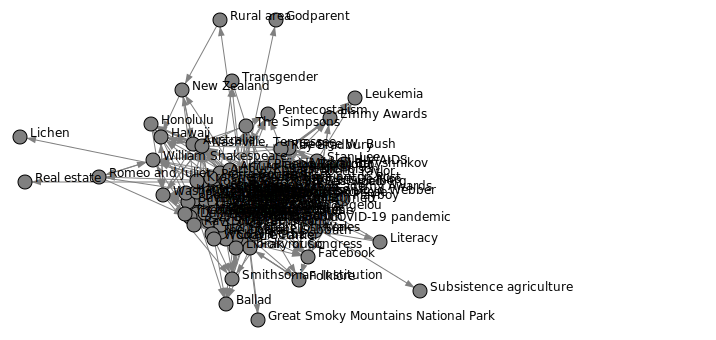

In [12]:
# 2471 and its neighbors in orginial graph
nei = np.concatenate((get_neighbors(adjacency, node=2471), np.array([2471])))
SVG(svg_graph(adjacency[nei, :][:, nei], names=names[nei]))

In [13]:
# 2471 and its neighbors in summarized graph
summarized_nodes = set()
for c in result:
    if 2471 in c[0] and len(c[1]) > 0:
        summarized_nodes |= set(c[0])
    
summarized_nodes = np.concatenate((np.array(list(summarized_nodes)), np.array([2471])))
summarized_nodes

array([2471, 5418, 3436, 1461, 3543,  893, 2471])

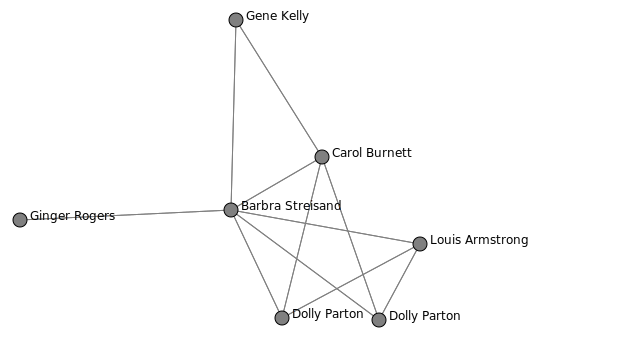

In [14]:
SVG(svg_graph(adjacency[summarized_nodes, :][:, summarized_nodes], names=names[summarized_nodes]))

**Summarized graph: combination of all concepts into one graph**  

All concepts are grouped into one graph to form the **summarized graph**. We analyze connected components in this summarized graph.

In [15]:
%%time

rows, cols = [], []

for c in result:
    
    # exclude first element of lattice 
    if len(c[1]) > 0:
        
        nodes = sorted(c[0])
        
        idx = 0
        idx_nodes = np.zeros(len(nodes)) # number of unique nodes from concepts
        
        # reindex nodes
        for n in nodes:
            if n not in idx_nodes:
                idx_nodes[idx] = n
                idx += 1
            
        # Record edges from subgraph related to concept
        adj_concept = adjacency[nodes, :][:, nodes].tocoo()
        reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
        reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
        rows += reindex_rows
        cols += reindex_cols

CPU times: user 45.9 ms, sys: 1.89 ms, total: 47.8 ms
Wall time: 47.4 ms


In [16]:
summarized_adjacency = sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()
summarized_adjacency

<10011x10011 sparse matrix of type '<class 'numpy.float64'>'
	with 3465 stored elements in Compressed Sparse Row format>

In [17]:
# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

808


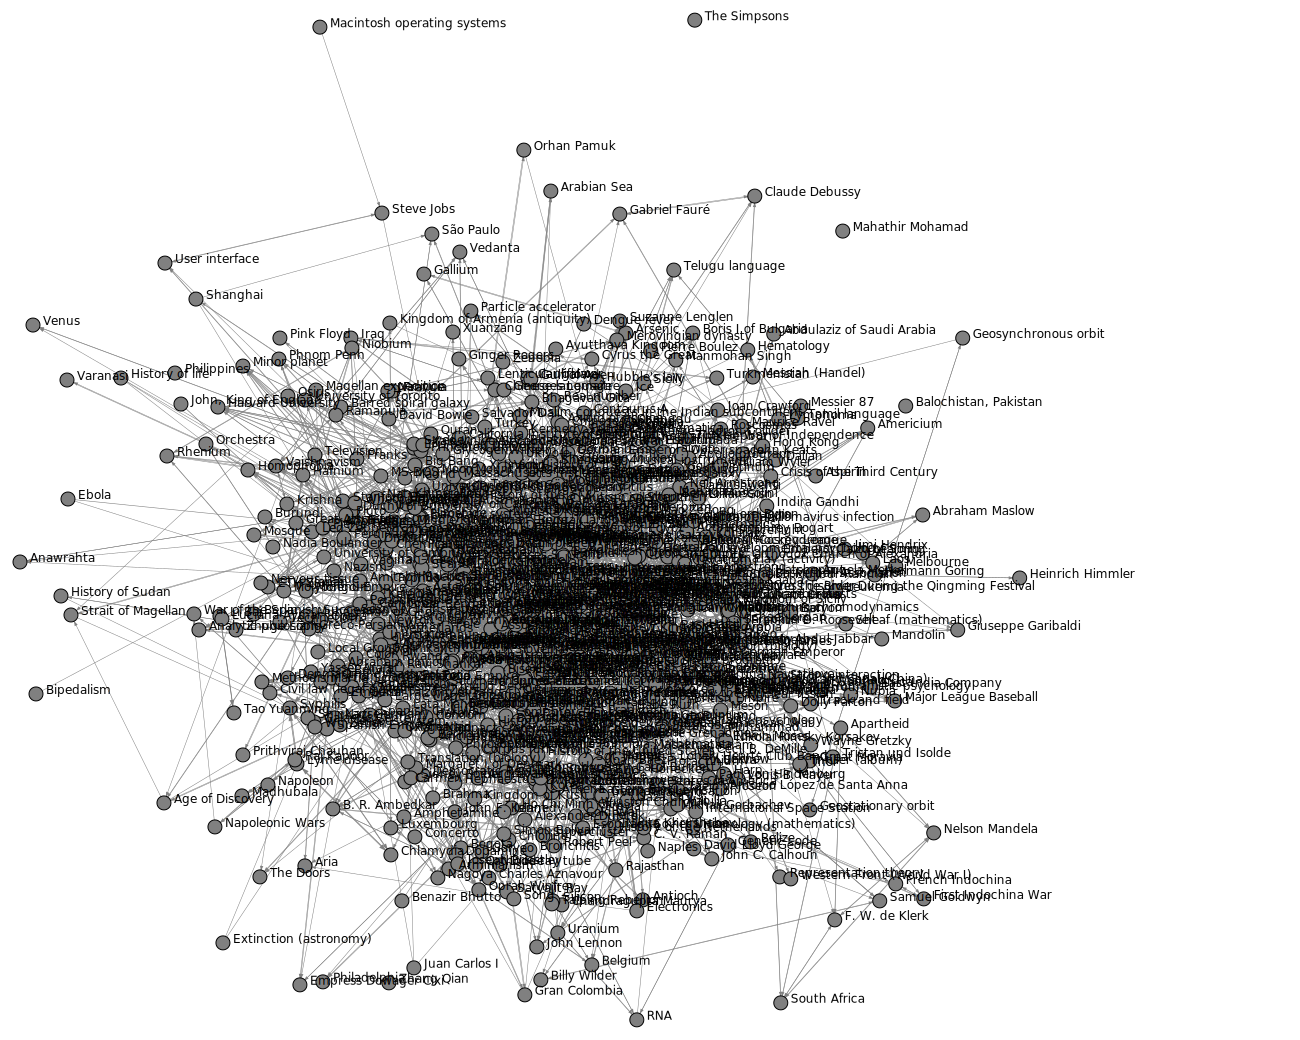

In [18]:
# Summarized graph
SVG(svg_graph(summarized_adjacency[mask, :][:, mask], names=names[mask], 
              edge_width_min=0.5, edge_width_max=2, 
              width=1000, height=1000))

**Summarized biadjacency**

In [87]:
summarized_biadjacency = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
for c in result:
    if len(c[1]) > 0:
        for node in c[0]:
            summarized_biadjacency[node, c[1]] += 1

summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency.astype(bool), shape=summarized_biadjacency.shape)

In [88]:
summarized_biadjacency

<10011x18338 sparse matrix of type '<class 'numpy.bool_'>'
	with 2309 stored elements in Compressed Sparse Row format>

**Connected components in summarized graph**

In [23]:
labels_cc = get_connected_components(adjacency)
Counter(labels_cc)

Counter({0: 10011})

In [24]:
labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
len(Counter(labels_cc_summarized))

101

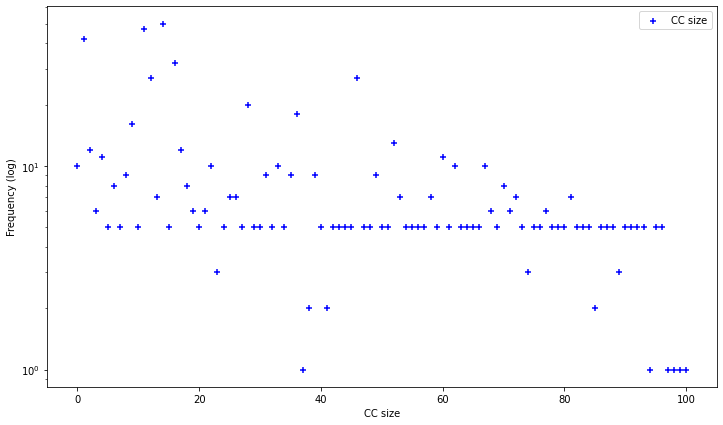

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib([x for x in labels_cc_summarized], log=False, ax=ax, label='CC size', xlabel='CC size')

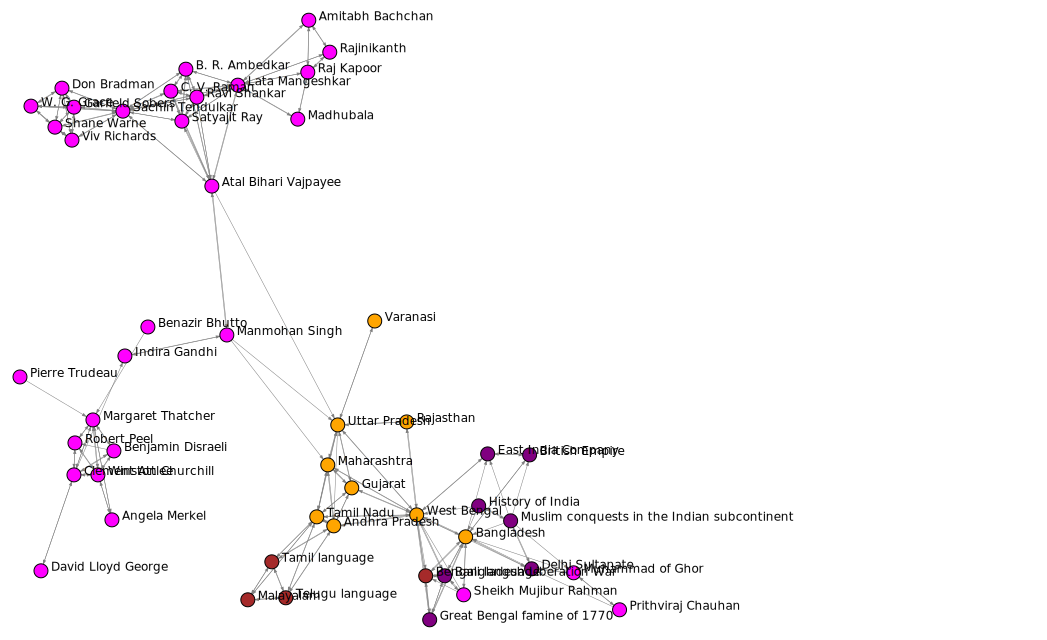

In [26]:
# Find biggest connected component
sorted(Counter(labels_cc_summarized).items(), key=lambda x: x[1], reverse=True)[0]

# Plot connected components
mask_cc = labels_cc_summarized == 14
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]
SVG(svg_graph(g_cc, names=names[mask][mask_cc], edge_width_min=0.5, edge_width_max=0.5, width=600, height=600, labels=labels[mask][mask_cc]))

In [569]:
mask_cc = labels_cc_summarized == 14
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]

# Unexpectedness of biggest component subgraph
u_g_cc = np.mean(complexity_gen_graphs.get(g_cc.shape[0])) - mdl_graph(g_cc)
print(f'U(subgraph): {u_g_cc:.4f}')

# Unexpectedness of biggest component subgraph attributes
g_cc_biadjacency = summarized_biadjacency[mask[mask_cc], :]
g_cc_attributes = np.flatnonzero(get_degrees(g_cc_biadjacency, transpose=True))
nb_attributes = len(g_cc_attributes)
print(nb_attributes)

complexity_gen_a = np.log2(special.comb(biadjacency.shape[1], nb_attributes))
complexity_desc_a = 0
for a in g_cc_attributes:
    complexity_desc_a += np.log2(sorted_degs[a])
u_g_cc_a = complexity_gen_a - complexity_desc_a
print(f'U(attributes): {u_g_cc_a:.4f}')
print(f'U: {u_g_cc + u_g_cc_a}')

U(subgraph): 1118.2580
29
U(attributes): 186.3981
U: 1304.6561595894268


### Impact of # of nodes and # of attributes on Unexpectedness

In [630]:
sizes_g = []
sizes_a_g = []
us_g = []

for idx in range(101):
    mask_cc = labels_cc_summarized == idx
    g = summarized_adjacency[mask, :][:, mask]
    g_cc = g[mask_cc, :][:, mask_cc].astype(bool)

    if g_cc.shape[0] > 3:
    
        # Unexpectedness of biggest component subgraph
        u_g_cc = np.mean(complexity_gen_graphs.get(g_cc.shape[0])) - mdl_graph(g_cc)
        if u_g_cc == np.inf:
            print(g_cc.shape, idx)

        # Unexpectedness of biggest component subgraph attributes
        g_cc_biadjacency = summarized_biadjacency[mask[mask_cc], :]
        g_cc_attributes = np.flatnonzero(get_degrees(g_cc_biadjacency, transpose=True))
        nb_attributes = len(g_cc_attributes)

        complexity_gen_a = np.log2(special.comb(biadjacency.shape[1], nb_attributes))
        complexity_desc_a = 0
        for a in g_cc_attributes:
            complexity_desc_a += np.log2(sorted_degs[a])
        u_g_cc_a = complexity_gen_a - complexity_desc_a

        sizes_g.append(g_cc.shape[0])
        sizes_a_g.append(nb_attributes)
        us_g.append(u_g_cc + u_g_cc_a)

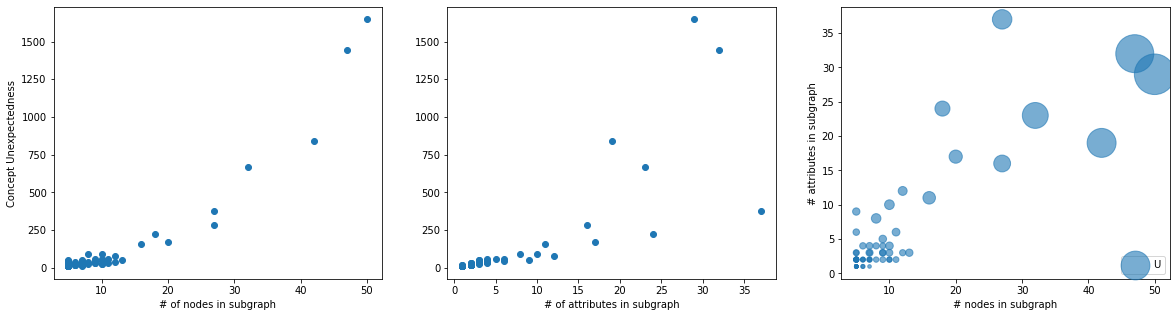

In [660]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(sizes_g, us_g)
ax[0].set_xlabel('# of nodes in subgraph')
ax[0].set_ylabel('Concept Unexpectedness')

ax[1].scatter(sizes_a_g, us_g)
ax[1].set_xlabel('# of attributes in subgraph')

ax[2].scatter(sizes_g, sizes_a_g, s=us_g, alpha=0.6, label='U')
ax[2].set_xlabel('# nodes in subgraph')
ax[2].set_ylabel('# attributes in subgraph')
plt.legend(loc='lower right');

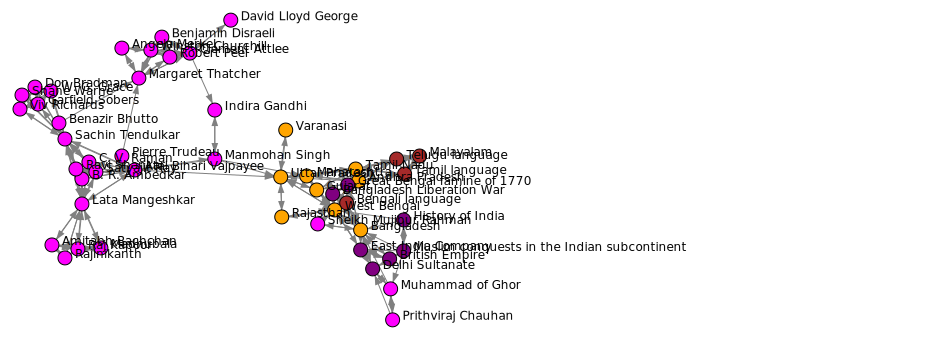

In [648]:
# Graph with highest number of nodes
idx = np.argsort(-np.array(sizes_g))[0]
mask_cc = labels_cc_summarized == idx# Graph with highest number of nodes
idx = np.argsort(-np.array(sizes_g))[0]
mask_cc = labels_cc_summarized == idx
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc].astype(bool)

SVG(svg_graph(g_cc, edge_width_max=0.5, labels=labels[mask][mask_cc], names=names[mask][mask_cc]))
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc].astype(bool)

SVG(svg_graph(g_cc, edge_width_max=0.5, labels=labels[mask][mask_cc], names=names[mask][mask_cc]))

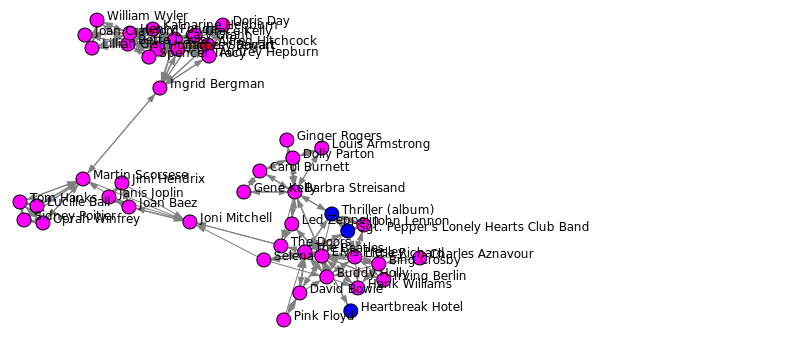

In [649]:
# Graph with second highest number of nodes
idx = np.argsort(-np.array(sizes_g))[1]
mask_cc = labels_cc_summarized == idx
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc].astype(bool)

SVG(svg_graph(g_cc, edge_width_max=0.5, labels=labels[mask][mask_cc], names=names[mask][mask_cc]))

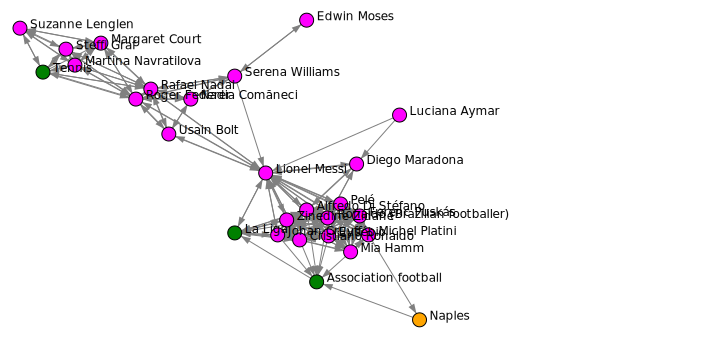

In [640]:
# Graph with highest number of attributes
idx = np.argsort(-np.array(sizes_a_g))[0]
mask_cc = labels_cc_summarized == idx
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc].astype(bool)

SVG(svg_graph(g_cc, edge_width_max=0.5, labels=labels[mask][mask_cc], names=names[mask][mask_cc]))

In [454]:
# Related concepts
concepts = []
g_cc_nodes = mask[mask_cc]

for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in g_cc_nodes:
                concepts.append(c)
                break
                
print(f'Number of concepts related to biggest connected component: {len(concepts)}')

Number of concepts related to biggest connected component: 25


In [455]:
for c in concepts[:10]:
    print(f'{(str(sorted_names_col[c[1]])):<25} - {(str(names[c[0]]))}')
    print()

['Lok']                   - ['Varanasi' 'Atal Bihari Vajpayee' 'Maharashtra' 'Manmohan Singh'
 'Uttar Pradesh']

['Puducherry']            - ['Telugu language' 'Tamil Nadu' 'Tamil language' 'Malayalam'
 'Andhra Pradesh']

['Filmfare' 'Award']      - ['Lata Mangeshkar' 'Madhubala' 'Raj Kapoor' 'Rajinikanth'
 'Amitabh Bachchan']

['lakh' 'billion']        - ['Bangalore' 'Visakhapatnam' 'West Bengal' 'Rajasthan' 'Uttar Pradesh']

['premiership' 'Prime']   - ['Clement Attlee' 'David Lloyd George' 'Indira Gandhi' 'Mahathir Mohamad'
 'Manmohan Singh']

['Plassey']               - ['Bangladesh' 'East India Company'
 'Muslim conquests in the Indian subcontinent' 'West Bengal'
 'British Empire']

['Nawabs']                - ['Lucknow' 'Bangladesh' 'Bhopal' 'History of India'
 'Muslim conquests in the Indian subcontinent' 'West Bengal']

['Nawabs' 'Delhi']        - ['Lucknow' 'Bangladesh' 'History of India'
 'Muslim conquests in the Indian subcontinent' 'West Bengal']

['Nawabs' 'Mughal']       

**Random connected component in summarized graph**

Number of concepts related to connected component: 5

['Baryon' 'Antiparticle' 'Hadron' 'Meson' 'Quantum chromodynamics' 'Quark'
 'Strong interaction'] - ['antiquark']

['Baryon' 'Hadron' 'Meson' 'Quantum chromodynamics' 'Quark'
 'Strong interaction'] - ['antiquark' 'hadron']

['Strong interaction' 'Meson' 'Quantum chromodynamics' 'Quark' 'Hadron'] - ['antiquark' 'hadron' 'meson']

['Antiparticle' 'Hadron' 'Meson' 'Quantum chromodynamics' 'Quark'
 'Strong interaction'] - ['antiquark' 'meson']

['Baryon' 'Antiparticle' 'Meson' 'Quark' 'Hadron'] - ['antiquark' 'antiparticle']



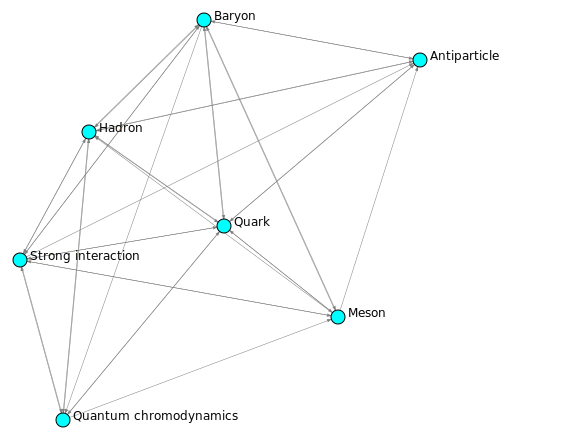

In [95]:
# Find random connected component in summarized graph
con_comps = list(Counter(labels_cc_summarized).items())
idx = np.random.choice(len(con_comps))
random_cc = con_comps[idx]

# Plot connected components
mask_cc = labels_cc_summarized == random_cc[0]
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]

# Related concepts
concepts = []
g_cc_nodes = mask[mask_cc]

for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in g_cc_nodes:
                concepts.append(c)
                break
                
print(f'Number of concepts related to connected component: {len(concepts)}')
print()

# Print related concepts
for c in concepts[:10]:
    print(f'{(str(names[c[0]]))} - {(str(sorted_names_col[c[1]]))}')
    print()
    
SVG(svg_graph(g_cc, names=names[mask][mask_cc], labels=labels[mask][mask_cc], edge_width_min=0.5, edge_width_max=0.5, width=400, height=400))

Number of concepts related to connected component: 9

['History of France' 'Duchy of Burgundy' 'Louis XVI' 'Capetian dynasty'
 'Kingdom of France'] - ['Capet' 'King']

['Spanish Empire' 'Napoleon' 'Napoleonic Wars'
 'War of the Spanish Succession' 'Capetian dynasty'] - ['Bourbons' 'Spain']

['Henry IV of France' 'History of France' 'John, King of England'
 'Louis XVI' 'Capetian dynasty' 'Kingdom of France'] - ['capetian']

['Henry IV of France' 'History of France' 'Louis XVI' 'Capetian dynasty'
 'Kingdom of France'] - ['capetian' 'Bourbon']

['Henry IV of France' 'History of France' 'John, King of England'
 'Capetian dynasty' 'Kingdom of France'] - ['capetian' 'Philip']

['Henry IV of France' 'History of France' 'Louis XVI' 'Capetian dynasty'
 'Kingdom of France'] - ['capetian' 'monarchy']

['Henry IV of France' 'History of France' 'John, King of England'
 'Louis XVI' 'Capetian dynasty'] - ['capetian' 'Louis']

['Henry IV of France' 'John, King of England' 'Louis XVI'
 'Capetian dynast

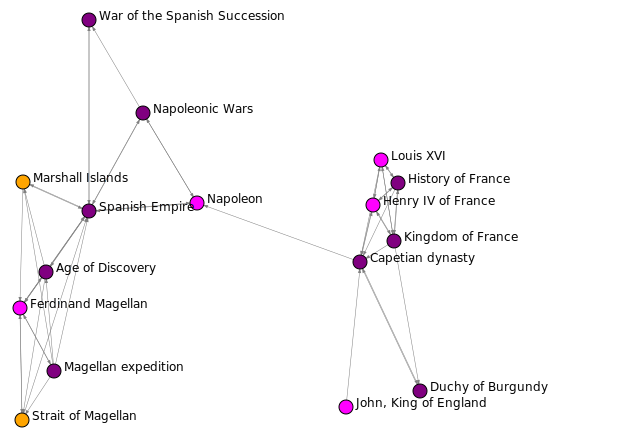

In [939]:
# Find random connected component in summarized graph
con_comps = list(Counter(labels_cc_summarized).items())
idx = np.random.choice(len(con_comps))
random_cc = con_comps[idx]

# Plot connected components
mask_cc = labels_cc_summarized == random_cc[0]
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]

# Related concepts
concepts = []
g_cc_nodes = mask[mask_cc]

for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in g_cc_nodes:
                concepts.append(c)
                break
                
print(f'Number of concepts related to connected component: {len(concepts)}')
print()

# Print related concepts
for c in concepts[:10]:
    print(f'{(str(names[c[0]]))} - {(str(sorted_names_col[c[1]]))}')
    print()
    
SVG(svg_graph(g_cc, names=names[mask][mask_cc], labels=labels[mask][mask_cc], edge_width_min=0.5, edge_width_max=0.5, width=400, height=400))

### Modularity of summarized graph

In [96]:
get_modularity(summarized_adjacency[mask, :][:, mask], labels_cc_summarized)

0.9487825176464852

In [97]:
get_modularity(adjacency, labels)

0.877831073806272

In [98]:
# Ratio between number of nodes in subgraph and number of unique true labels
res = 0
tot = 0
for community in range(101):
    cc_mask = labels_cc_summarized == community
    labels_community = labels[mask][cc_mask]
    res += len(labels_community) / len(np.unique(labels_community))
    tot += len(np.unique(labels_community))
res / tot

2.097630718954249

### Baselines

#### Louvain

In [27]:
louvain = Louvain(resolution=6.3)
labels_louvain = louvain.fit_transform(adjacency)

In [28]:
get_modularity(adjacency, labels_louvain)

0.9834059681761088

In [29]:
sorted(Counter(labels_louvain).items(), key=lambda x: x[1], reverse=True)[0]

(0, 457)

In [30]:
len(Counter(labels_louvain))

100

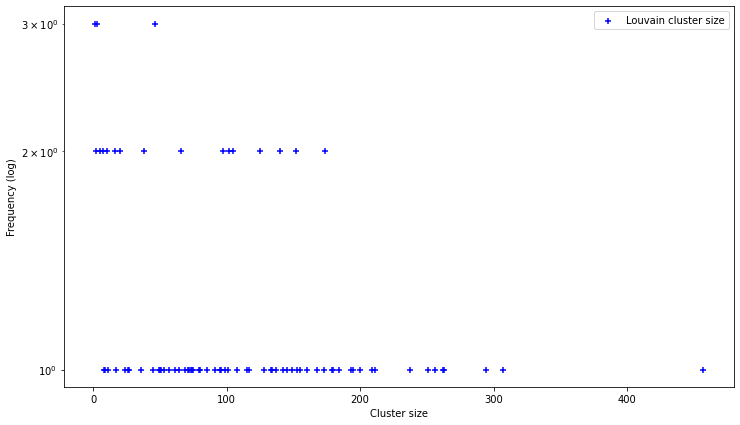

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib([y for x, y in Counter(labels_louvain).items()], ax=ax, log=False, label='Louvain cluster size', xlabel='Cluster size')

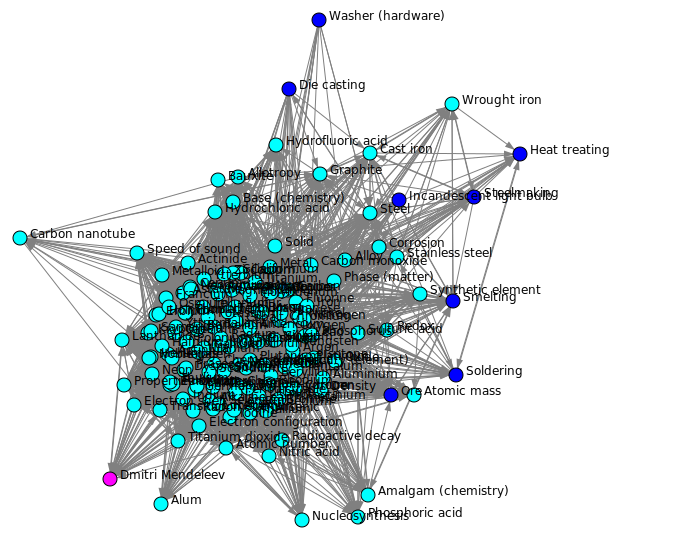

In [32]:
idx_cluster = np.random.choice(100)
louvain_mask = labels_louvain == idx_cluster
SVG(svg_graph(adjacency[louvain_mask, :][:, louvain_mask], labels=labels[louvain_mask], width=500, height=500, names=names[louvain_mask]))

In [33]:
# Ratio between number of nodes in subgraph and number of unique true labels
res = 0
tot = 0
for community in range(100):
    louvain_mask = labels_louvain == community
    labels_community = labels[louvain_mask]
    res += len(labels_community) / len(np.unique(labels_community))
    tot += len(np.unique(labels_community))
res / tot

3.1231028582930764

In [ ]:
louvain_mask = labels_louvain == 0
g_cc = adjacency[louvain_mask, :][:, louvain_mask]

# Unexpectedness of biggest Louvain cluster 
u_g_cc = np.mean(complexity_gen_graphs.get(g_cc.shape[0])) - mdl_graph(g_cc)
print(f'U(subgraph): {u_g_cc:.4f}')

# Unexpectedness of biggest Louvain cluster attributes
max_nb_attributes = 29 # number of attributes in biggest connected component from summarized graph
g_cc_biadjacency = biadjacency[louvain_mask, :]
g_cc_attributes = np.argsort(-get_degrees(g_cc_biadjacency, transpose=True))[:max_nb_attributes]

complexity_gen_a = np.log2(special.comb(biadjacency.shape[1], max_nb_attributes))
complexity_desc_a = 0
for a in g_cc_attributes:
    complexity_desc_a += np.log2(freq_attribute[a])
    
u_g_cc_a = complexity_gen_a - complexity_desc_a
print(f'U(attributes): {u_g_cc_a:.4f}')
print(f'U: {u_g_cc + u_g_cc_a}')

#### GNN + KMeans

In [99]:
# Features
features = biadjacency

hidden_dim = 32
n_labels = len(np.unique(labels))

# GNN classifier 
gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layers='GCNConv',
                    activations=['Relu', 'Softmax'],
                    verbose=True)

gnn.fit(adjacency, features, labels, train_size=0.8, val_size=0.1, test_size=0.1, n_epochs=50)

In epoch   0, loss: 3.275, training acc: 0.068, val acc: 0.075
In epoch   5, loss: 1.249, training acc: 0.632, val acc: 0.626
In epoch  10, loss: 0.959, training acc: 0.718, val acc: 0.743
In epoch  15, loss: 0.839, training acc: 0.753, val acc: 0.757
In epoch  20, loss: 0.792, training acc: 0.766, val acc: 0.777
In epoch  25, loss: 0.760, training acc: 0.784, val acc: 0.785
In epoch  30, loss: 0.724, training acc: 0.793, val acc: 0.798
In epoch  35, loss: 0.702, training acc: 0.800, val acc: 0.805
In epoch  40, loss: 0.689, training acc: 0.805, val acc: 0.813
In epoch  45, loss: 0.679, training acc: 0.812, val acc: 0.812


GNNClassifier(
    GCNConv(out_channels: 32, activation: relu, use_bias: True, self_loops: True)
    GCNConv(out_channels: 11, activation: softmax, use_bias: True, self_loops: True)
)

In [100]:
# KMeans on GNN node embedding
gnn_embedding = gnn.conv2.update

kmeans = KMeansDense(n_clusters=101) # k = number of connected components in summarized graph
kmeans_gnn_labels = kmeans.fit_transform(gnn_embedding)

In [101]:
# Biggest KMeans cluster
sorted(Counter(kmeans_gnn_labels).items(), key=lambda x: x[1], reverse=True)[0]

(41, 265)

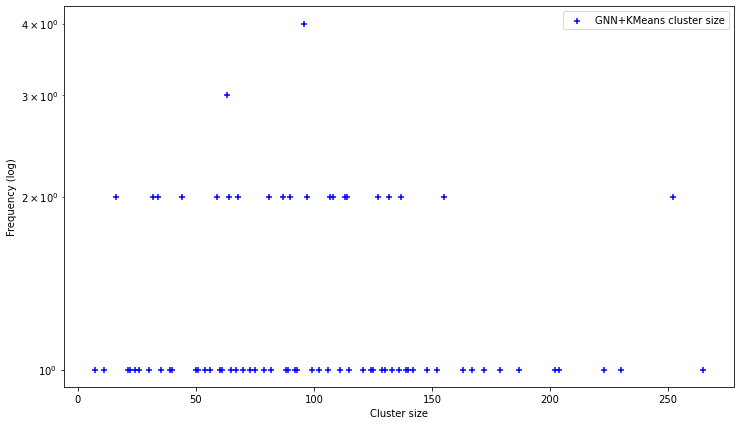

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib([y for x, y in Counter(kmeans_gnn_labels).items()], ax=ax, log=False, label='GNN+KMeans cluster size', xlabel='Cluster size')

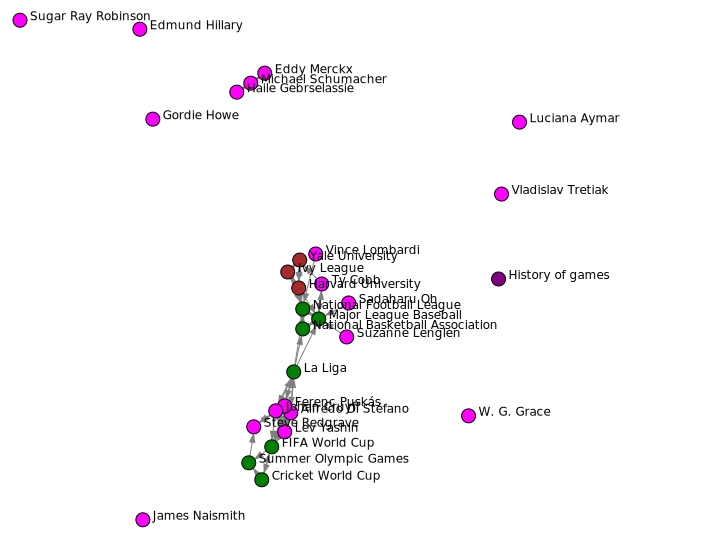

In [108]:
idx_cluster = np.random.choice(101)
kmeans_mask = kmeans_gnn_labels == idx_cluster
SVG(svg_graph(adjacency[kmeans_mask, :][:, kmeans_mask], labels=labels[kmeans_mask], width=500, height=500, names=names[kmeans_mask]))

In [109]:
# Ratio between number of nodes in subgraph and number of unique true labels
res = 0
tot = 0
for community in range(101):
    kmeans_mask = kmeans_gnn_labels == community
    labels_community = labels[kmeans_mask]
    res += len(labels_community) / len(np.unique(labels_community))
    tot += len(np.unique(labels_community))
res / tot

5.784710236000557

In [110]:
# Modularity of clustering using GNN + KMeans
get_modularity(adjacency, kmeans_gnn_labels)

0.9856979175251838

#### Spectral + KMeans

In [44]:
kmeans = KMeans(n_clusters=101) # k = number of connected components in summarized graph
kmeans_spectral_labels = kmeans.fit_transform(adjacency)

In [45]:
# Biggest KMeans cluster
sorted(Counter(kmeans_spectral_labels).items(), key=lambda x: x[1], reverse=True)[0]

(0, 321)

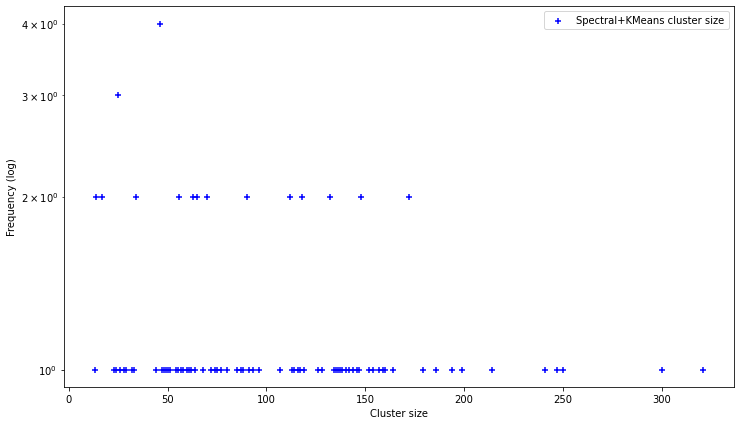

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib([y for x, y in Counter(kmeans_spectral_labels).items()], ax=ax, log=False, label='Spectral+KMeans cluster size', xlabel='Cluster size')

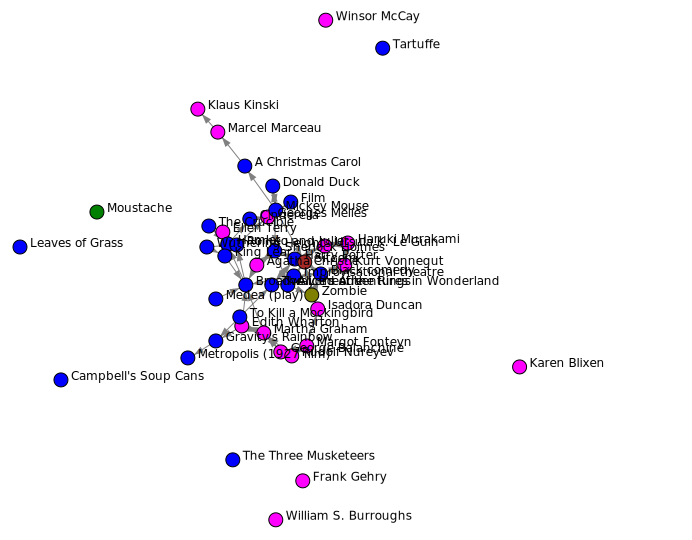

In [47]:
idx_cluster = 82 # np.random.choice(101)
kmeans_mask = kmeans_spectral_labels == idx_cluster
SVG(svg_graph(adjacency[kmeans_mask, :][:, kmeans_mask], labels=labels[kmeans_mask], width=500, height=500, names=names[kmeans_mask]))

In [48]:
# Classic modularity
get_modularity(adjacency, kmeans_spectral_labels)

0.9830406251504844

In [49]:
# Ratio between number of nodes in subgraph and number of unique true labels
res = 0
tot = 0
for community in range(101):
    kmeans_mask = kmeans_spectral_labels == community
    labels_community = labels[kmeans_mask]
    res += len(labels_community) / len(np.unique(labels_community))
    tot += len(np.unique(labels_community))
res / tot

2.638481287083523

### Modularity on attributed graph  

Redefine modularity using:
$$
Q_a = \dfrac{1}{w}\sum_{ij}\biggl(A_{ij} - \gamma \dfrac{d^{+}_i d^{-}_j} {w} \biggl) \delta_{c_i, c_j} x_i^{T}x_j
$$

In [111]:
def new_modularity(adjacency, labels, features, mask, concepts, resolution = 1, consider_attr=False):
    
    if mask is not None:
        summarized_biadjacency = np.zeros((adjacency.shape[0], features.shape[1]))

        for c in result:
            if len(c[1]) > 0:
                for node in c[0]:
                    summarized_biadjacency[node, c[1]] += 1

        summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency, shape=summarized_biadjacency.shape)
        adjacency = adjacency[mask, :][:, mask].astype(float)
        summarized_biadjacency = summarized_biadjacency[mask, :][:, mask]
        
    else:
        adjacency = adjacency.astype(float)
        summarized_biadjacency = features

    n = adjacency.shape[0]
    
    probs_row = get_probs('degree', adjacency)
    probs_col = get_probs('degree', adjacency.T)
    membership = get_membership(labels)
    
    fit: float = membership.T.dot(adjacency.dot(membership)).data.sum() / adjacency.data.sum()
    div: float = membership.T.dot(probs_col).dot(membership.T.dot(probs_row))
    attrs: float = membership.T.dot(summarized_biadjacency).dot((membership.T.dot(summarized_biadjacency)).T).data.sum() / (summarized_biadjacency.data.sum()**2)
    
    if consider_attr:
        print(fit, div, attrs)
        mod: float = fit - resolution * div * attrs
    else:
        mod: float = fit - resolution * div #* attrs

    return mod

In [112]:
get_membership(labels_louvain).T.dot(biadjacency)

<100x18338 sparse matrix of type '<class 'numpy.int64'>'
	with 266224 stored elements in Compressed Sparse Column format>

In [113]:
print(f'Without condidering attributes')
print(new_modularity(summarized_adjacency, labels_cc_summarized, filt_biadjacency, mask, result))
print(new_modularity(adjacency, kmeans_spectral_labels, biadjacency, None, result))
print(new_modularity(adjacency, kmeans_gnn_labels, biadjacency, None, result))
print(new_modularity(adjacency, labels_louvain, biadjacency, None, result))

print(f'Condidering attributes')
print(new_modularity(summarized_adjacency, labels_cc_summarized, filt_biadjacency, mask, result, consider_attr=True))
print(new_modularity(adjacency, kmeans_spectral_labels, biadjacency, None, result, consider_attr=True))
print(new_modularity(adjacency, kmeans_gnn_labels, biadjacency, None, result, consider_attr=True))
print(new_modularity(adjacency, labels_louvain, biadjacency, None, result, consider_attr=True))

Without condidering attributes
0.9487825176464852
0.9830406251504844
0.9856979175251838
0.9834059681761088
Condidering attributes
1.0 0.05121748235351481 0.08009435595567867
0.9958977687372239
1.0 0.016959374849515575 0.0003345221643893912
0.9999943267132186
1.0 0.014302082474816206 0.0003345221643893912
0.9999952156364152
1.0 0.016594031823891145 0.0003345221643893912
0.9999944489285584


In [305]:
def new_modularity(adjacency, labels, features, mask, concepts, resolution = 1):
    
    if mask is not None:
        summarized_biadjacency = np.zeros((adjacency.shape[0], features.shape[1]))

        for c in result:
            if len(c[1]) > 0:
                for node in c[0]:
                    summarized_biadjacency[node, c[1]] += 1

        summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency.astype(bool), shape=summarized_biadjacency.shape)
        pairwise_product = summarized_biadjacency[mask, :].dot(summarized_biadjacency[mask, :].T)
        
        adjacency = adjacency[mask, :][:, mask].astype(bool)
        
    else:
        adjacency = adjacency.astype(bool)
        pairwise_product = biadjacency.astype(bool).dot(biadjacency.astype(bool).T)

    
    n = adjacency.shape[0]
    
    mod = 0
    degrees_pos = get_degrees(adjacency)
    degrees_neg = get_degrees(adjacency, transpose=True)
    w = np.sum(adjacency)
    
    for src in range(n):
        for dst in range(n):
            a = adjacency[src, dst].astype(int)
            deg_pos = degrees_pos[src]
            deg_neg = degrees_neg[dst]

            if labels[src] == labels[dst]:
                mod += (a - resolution * (deg_pos * deg_neg) / w) * pairwise_product[src, dst]
            
    return (1 / w) * mod

In [306]:
new_modularity(summarized_adjacency, labels_cc_summarized, filt_biadjacency, mask, result)

0.9859020045141591

In [44]:
# without pairwise product
new_modularity(summarized_adjacency, labels_cc_summarized, filt_biadjacency, mask, result)

0.9692983663391177

In [54]:
# Modularity using attributes on GNN + KMeans clustering
new_modularity(adjacency, kmeans_labels, biadjacency, None, result)

0.23352082536668775

In [232]:
# Modularity without attributes on GNN + KMeans
get_modularity(adjacency, kmeans_gnn_labels)

0.985750880618501

In [235]:
# Modularity using attributes on Spectral + KMeans clustering
new_modularity(adjacency, kmeans_spectral_labels, biadjacency, None, result)

0.13382448833227537

In [334]:
print(f'Coverage = {summarized_adjacency[mask, :][:, mask].shape[0] / n}')
print(f'Diversity = {get_degrees(summarized_biadjacency, transpose=True).astype(bool).sum() / biadjacency.shape[1]}')

Coverage = 0.08814224937275009
Diversity = 0.020940124331988223


#### Density of clusters

Edge density
$$
\delta(C) = \dfrac{1}{|\mathcal{E}|}\sum_{C_i \in C}|E(C_i)|
$$

In [53]:
biadjacency.shape

(10011, 18338)

In [54]:
def clustering_density(adjacency, biadjacency, labels_clustering, mask=None):
    density_ccs = 0
    nb_clusters = len(np.unique(labels_clustering))

    for c  in range(nb_clusters):
        # Filter adjacency w.r.t connected component
        mask_cc = labels_clustering == c
        adj_mask_cc = adjacency[mask_cc, :][:, mask_cc]
        n, m = adj_mask_cc.shape[0], adj_mask_cc.nnz
        
        # Compute cumulated density of ccs
        density_ccs += m
        
    return (1 / adjacency.nnz) * density_ccs

In [55]:
density_cc = clustering_density(summarized_adjacency, summarized_biadjacency, labels_cc_summarized, mask)
print(f'Density of summarized graph: {density_cc}')

Density of summarized graph: 0.003751803751803752


In [56]:
density_cc = clustering_density(adjacency, biadjacency, labels_louvain, None)
print(f'Density of Louvain clustering: {density_cc}')

density_cc = clustering_density(adjacency, biadjacency, kmeans_gnn_labels, None)
print(f'Density of GNN + KMeans clustering: {density_cc}')

density_cc = clustering_density(adjacency, biadjacency, kmeans_spectral_labels, None)
print(f'Density of Spectral + KMeans clustering: {density_cc}')

Density of Louvain clustering: 0.3670598388604107
Density of GNN + KMeans clustering: 0.17523778816701596
Density of Spectral + KMeans clustering: 0.2574584938890835


In [832]:
%%time
km_gnn_dens = []
km_spec_dens = []

for k in np.arange(50, 200):
    kmeans = KMeansDense(n_clusters=k)
    kmeans_gnn_labels_k = kmeans.fit_transform(gnn_embedding)
    km_gnn_dens.append(clustering_entropy(adjacency, biadjacency, kmeans_gnn_labels_k, None))
    
    kmeans = KMeans(n_clusters=k)
    kmeans_spec_labels_k = kmeans.fit_transform(adjacency)
    km_spec_dens.append(clustering_entropy(adjacency, biadjacency, kmeans_spec_labels_k, None))

CPU times: user 9min 59s, sys: 38.5 s, total: 10min 38s
Wall time: 15min 38s


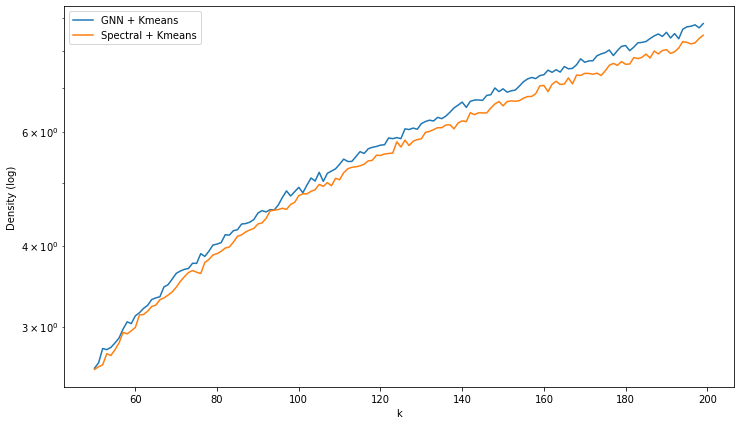

In [834]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.plot(np.arange(50, 200), km_gnn_dens, label='GNN + Kmeans')
plt.plot(np.arange(50, 200), km_spec_dens, label='Spectral + Kmeans')
plt.xlabel('k')
plt.ylabel('Density (log)')
plt.yscale('log')
plt.legend();

#### Entropy of clusters

*Source: https://arxiv.org/pdf/1501.01676.pdf*

$$
\mathcal{H}(C) = \dfrac{1}{|\mathcal{V}|}\sum_{C_i \in C}H(C_i)
$$
with 
$$
H(C_i) = - \sum_{j \in A_i} p_{ij} \log_{2} p_{ij}
$$
where $p_{ij}$ is the fraction of nodes in the community $C_i$ that share attribute $j$.

In [57]:
def clustering_entropy(adjacency, biadjacency, labels_clustering, mask=None):
    entropy_ccs = 0
    nb_clusters = len(np.unique(labels_clustering))

    for c  in range(nb_clusters):
        
        # Filter adjacency w.r.t connected component
        mask_cc = labels_clustering == c
        adj_mask_cc = adjacency[mask_cc, :][:, mask_cc]
        n, m = adj_mask_cc.shape[0], adj_mask_cc.nnz

        # Compute cumulated entropy of ccs
        if mask is not None:
            biadjacency_mask = biadjacency[mask, :]
        else:
            biadjacency_mask = biadjacency
        biadjacency_mask_cc = biadjacency_mask[mask_cc, :]
        degrees_attrs_cc = get_degrees(biadjacency_mask_cc, transpose=True) 

        entropy_cc = 0
        for d in degrees_attrs_cc[np.flatnonzero(degrees_attrs_cc)]:
            p = d / n
            entropy_cc += p * np.log2(p)

        # Update total entropy of clustering
        entropy_ccs -= entropy_cc

    return entropy_ccs / adjacency.shape[0]

In [58]:
ent = clustering_entropy(summarized_adjacency, summarized_biadjacency, labels_cc_summarized, mask)
print(f'Entropy of summarized graph: {ent}')

Entropy of summarized graph: 0.01321534725554561


In [59]:
ent = clustering_entropy(adjacency, biadjacency, labels_louvain, None)
print(f'Entropy of Louvain clusters: {ent}')

ent = clustering_entropy(adjacency, biadjacency, kmeans_gnn_labels, None)
print(f'Entropy of GNN + KMeans clusters: {ent}')

ent = clustering_entropy(adjacency, biadjacency, kmeans_spectral_labels, None)
print(f'Entropy of Spectral + KMeans clusters: {ent}')

Entropy of Louvain clusters: 3.434325519059572
Entropy of GNN + KMeans clusters: 3.923752349283669
Entropy of Spectral + KMeans clusters: 3.8294942845963953


In [809]:
%%time
km_gnn_ents = []
km_spec_ents = []

for k in np.arange(50, 200):
    kmeans = KMeansDense(n_clusters=k)
    kmeans_gnn_labels_k = kmeans.fit_transform(gnn_embedding)
    km_gnn_ents.append(clustering_entropy(adjacency, biadjacency, kmeans_gnn_labels_k, None))
    
    kmeans = KMeans(n_clusters=k)
    kmeans_spec_labels_k = kmeans.fit_transform(adjacency)
    km_spec_ents.append(clustering_entropy(adjacency, biadjacency, kmeans_spec_labels_k, None))

CPU times: user 9min 52s, sys: 38.4 s, total: 10min 30s
Wall time: 6min 16s


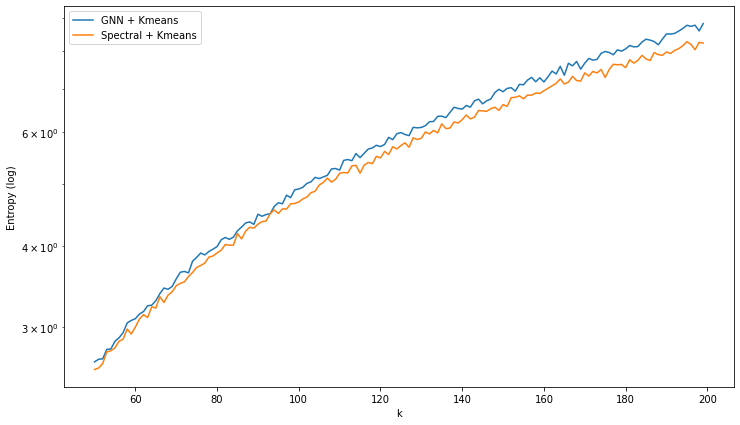

In [815]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.plot(np.arange(50, 200), km_gnn_ents, label='GNN + Kmeans')
plt.plot(np.arange(50, 200), km_spec_ents, label='Spectral + Kmeans')
plt.xlabel('k')
plt.ylabel('Entropy (log)')
plt.yscale('log')
plt.legend();

### Wasserstein distance between concepts  

**RQ**: Are the subgraphs obtained with the algorithm distant from each others?  

We would like our algorithm to find concepts distant from each others, in order not to get redundant explanations of the initial graph. 

**Method**:
* Embed each concet/community using Spectral Embedding ($k=100$)
* Compute Wasserstein distance between pairs of embeddings
* Compute average Wasserstein distance for all pairs

In [60]:
from scipy.stats import wasserstein_distance

**On attributes**

In [62]:
wd_matrix = np.zeros((len(result), len(result)))

# Unexpectedness algorithm + concepts
concept_attributes = np.zeros((len(result), biadjacency.shape[1]))

for i, c in enumerate(result[1:]):
    concept_attributes[i, c[1]] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_attributes)

for i, c1 in enumerate(result[1:]):
    for j, c2 in enumerate(result[1:]):    
        wd_matrix[i, j] = wasserstein_distance(emb[i], emb[j])

In [63]:
%%time

# Unexpectedness algorithm + summarized graph
nb_cc = len(np.unique(labels_cc_summarized))
wd_matrix_summarized = np.zeros((nb_cc, nb_cc))

concept_summarized_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = labels_cc_summarized == c
    indices_attr = np.flatnonzero(get_degrees(summarized_biadjacency[mask][mask_cc].astype(bool), transpose=True))
    concept_summarized_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_summarized_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_summarized[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 3.29 s, sys: 183 ms, total: 3.48 s
Wall time: 1.05 s


In [64]:
%%time

# Louvain Algorithm
nb_cc = len(np.unique(labels_louvain))
wd_matrix_louvain = np.zeros((nb_cc, nb_cc))

concept_louvain_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = labels_louvain == c
    indices_attr = np.flatnonzero(get_degrees(biadjacency[mask_cc].astype(bool), transpose=True))
    concept_louvain_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_louvain_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_louvain[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 2.53 s, sys: 128 ms, total: 2.66 s
Wall time: 996 ms


In [65]:
%%time

# GNN + KMeans Algorithm
nb_cc = len(np.unique(kmeans_gnn_labels))
wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))

concept_gnn_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = kmeans_gnn_labels == c
    indices_attr = np.flatnonzero(get_degrees(biadjacency[mask_cc].astype(bool), transpose=True))
    concept_gnn_kmeans_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_gnn_kmeans_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_gnn_kmeans[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 2.58 s, sys: 128 ms, total: 2.71 s
Wall time: 1.02 s


In [66]:
%%time

# Spectral + KMeans Algorithm
nb_cc = len(np.unique(kmeans_spectral_labels))
wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))

concept_spectral_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = kmeans_spectral_labels == c
    indices_attr = np.flatnonzero(get_degrees(biadjacency[mask_cc].astype(bool), transpose=True))
    concept_spectral_kmeans_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_spectral_kmeans_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_spectral_kmeans[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 2.52 s, sys: 128 ms, total: 2.65 s
Wall time: 1 s


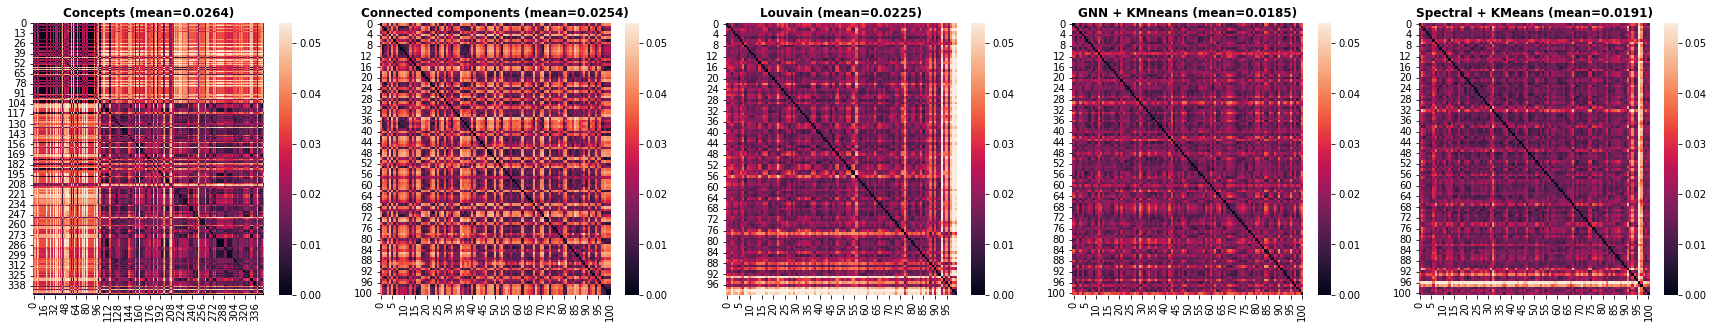

In [67]:
min_wd = np.min(wd_matrix_summarized)
max_wd = np.max(wd_matrix_summarized)

# Plot Wasserstein distances
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
sns.heatmap(wd_matrix, ax=ax[0], vmin=min_wd, vmax=max_wd)
sns.heatmap(wd_matrix_summarized, ax=ax[1], vmin=min_wd, vmax=max_wd)
sns.heatmap(wd_matrix_louvain, ax=ax[2], vmin=min_wd, vmax=max_wd)
sns.heatmap(wd_matrix_gnn_kmeans, ax=ax[3], vmin=min_wd, vmax=max_wd)
sns.heatmap(wd_matrix_spectral_kmeans, ax=ax[4], vmin=min_wd, vmax=max_wd)

titles = ['Concepts', 'Connected components', 'Louvain', 'GNN + KMneans', 'Spectral + KMeans']
avgs = [np.mean(x) for x in [wd_matrix, wd_matrix_summarized, wd_matrix_louvain, wd_matrix_gnn_kmeans, wd_matrix_spectral_kmeans]]
for i in range(5):
    ax[i].set_title(f'{titles[i]} (mean={avgs[i]:.4f})', weight='bold');

**Impact of Spectral embedding size**

In [68]:
ks = [5, 25, 50, 100, 125, 150, 175, 200]
avgs = defaultdict(list)


nb_cc = len(np.unique(labels_cc_summarized))
nb_louvain = len(np.unique(labels_louvain))
wd_matrix = np.zeros((len(result), len(result)))
wd_matrix_summarized = np.zeros((nb_cc, nb_cc))
wd_matrix_louvain = np.zeros((nb_louvain, nb_louvain))
wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))
wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))

for k in ks: 
    # Unexpectedness algorithm + concepts
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_attributes)
    for i, c1 in enumerate(result[1:]):
        for j, c2 in enumerate(result[1:]):    
            wd_matrix[i, j] = wasserstein_distance(emb[i], emb[j])
    avgs['concepts'].append(np.mean(wd_matrix))
    
    # Louvain
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_louvain_attributes)
    for i in range(nb_louvain):
        for j in range(nb_louvain):    
            wd_matrix_louvain[i, j] = wasserstein_distance(emb[i], emb[j])
    avgs['louvain'].append(np.mean(wd_matrix_louvain))
    
    # Others
    spectral_summarized = Spectral(k)
    emb_summarized = spectral_summarized.fit_transform(concept_summarized_attributes)
    spectral_spectral_kmeans = Spectral(k)
    emb_spectral_kmeans = spectral_spectral_kmeans.fit_transform(concept_spectral_kmeans_attributes)
    spectral_gnn_kmeans = Spectral(k)
    emb_gnn_kmeans = spectral_gnn_kmeans.fit_transform(concept_gnn_kmeans_attributes)
    for i in range(nb_cc):
        for j in range(nb_cc):    
            wd_matrix_summarized[i, j] = wasserstein_distance(emb_summarized[i], emb_summarized[j])
            wd_matrix_spectral_kmeans[i, j] = wasserstein_distance(emb_spectral_kmeans[i], emb_spectral_kmeans[j])
            wd_matrix_gnn_kmeans[i, j] = wasserstein_distance(emb_gnn_kmeans[i], emb_gnn_kmeans[j])
    avgs['summarized'].append(np.mean(wd_matrix_summarized))
    avgs['spectral_kmeans'].append(np.mean(wd_matrix_spectral_kmeans))
    avgs['gnn_kmeans'].append(np.mean(wd_matrix_gnn_kmeans))

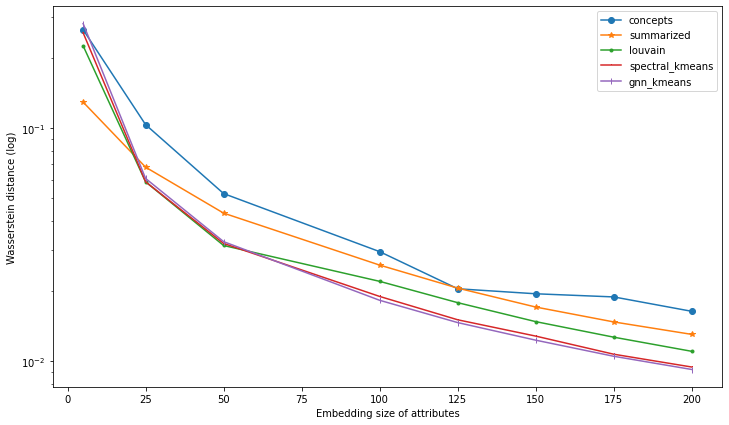

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
markers = ['o', '*', '.', ',', '|']
for i, method in enumerate(['concepts', 'summarized', 'louvain', 'spectral_kmeans', 'gnn_kmeans']):
    plt.plot(ks, avgs.get(method), label=method, marker=markers[i])
plt.yscale('log')
plt.xlabel('Embedding size of attributes')
plt.ylabel('Wasserstein distance (log)')
plt.legend();

#### Hamming distance

In [70]:
from scipy.spatial.distance import hamming

ks = [5, 25, 50, 100, 125, 150, 175, 200]
avgs = defaultdict(list)


nb_cc = len(np.unique(labels_cc_summarized))
nb_louvain = len(np.unique(labels_louvain))
wd_matrix = np.zeros((len(result), len(result)))
wd_matrix_summarized = np.zeros((nb_cc, nb_cc))
wd_matrix_louvain = np.zeros((nb_louvain, nb_louvain))
wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))
wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))

for k in ks: 
    # Unexpectedness algorithm + concepts
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_attributes)
    for i, c1 in enumerate(result[1:]):
        for j, c2 in enumerate(result[1:]):    
            wd_matrix[i, j] = hamming(emb[i], emb[j])
    avgs['concepts'].append(np.mean(wd_matrix))
    
    # Louvain
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_louvain_attributes)
    for i in range(nb_louvain):
        for j in range(nb_louvain):    
            wd_matrix_louvain[i, j] = hamming(emb[i], emb[j])
    avgs['louvain'].append(np.mean(wd_matrix_louvain))
    
    # Others
    spectral_summarized = Spectral(k)
    emb_summarized = spectral_summarized.fit_transform(concept_summarized_attributes)
    spectral_spectral_kmeans = Spectral(k)
    emb_spectral_kmeans = spectral_spectral_kmeans.fit_transform(concept_spectral_kmeans_attributes)
    spectral_gnn_kmeans = Spectral(k)
    emb_gnn_kmeans = spectral_gnn_kmeans.fit_transform(concept_gnn_kmeans_attributes)
    for i in range(nb_cc):
        for j in range(nb_cc):    
            wd_matrix_summarized[i, j] = hamming(emb_summarized[i], emb_summarized[j])
            wd_matrix_spectral_kmeans[i, j] = hamming(emb_spectral_kmeans[i], emb_spectral_kmeans[j])
            wd_matrix_gnn_kmeans[i, j] = hamming(emb_gnn_kmeans[i], emb_gnn_kmeans[j])
    avgs['summarized'].append(np.mean(wd_matrix_summarized))
    avgs['spectral_kmeans'].append(np.mean(wd_matrix_spectral_kmeans))
    avgs['gnn_kmeans'].append(np.mean(wd_matrix_gnn_kmeans))

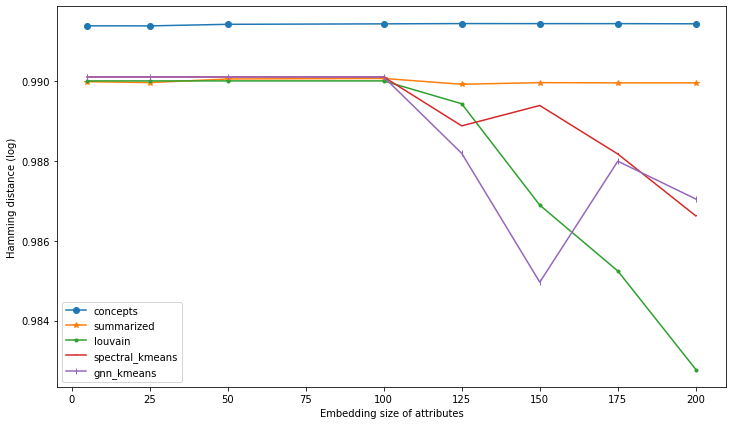

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
markers = ['o', '*', '.', ',', '|']
for i, method in enumerate(['concepts', 'summarized', 'louvain', 'spectral_kmeans', 'gnn_kmeans']):
    plt.plot(ks, avgs.get(method), label=method, marker=markers[i])
#plt.yscale('log')
plt.xlabel('Embedding size of attributes')
plt.ylabel('Hamming distance (log)')
plt.legend();

#### Euclidean distance

In [72]:
from scipy.spatial.distance import euclidean

ks = [5, 25, 50, 100, 125, 150, 175, 200]
avgs = defaultdict(list)


nb_cc = len(np.unique(labels_cc_summarized))
nb_louvain = len(np.unique(labels_louvain))
wd_matrix = np.zeros((len(result), len(result)))
wd_matrix_summarized = np.zeros((nb_cc, nb_cc))
wd_matrix_louvain = np.zeros((nb_louvain, nb_louvain))
wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))
wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))

for k in ks: 
    # Unexpectedness algorithm + concepts
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_attributes)
    for i, c1 in enumerate(result[1:]):
        for j, c2 in enumerate(result[1:]):    
            wd_matrix[i, j] = euclidean(emb[i], emb[j])
    avgs['concepts'].append(np.mean(wd_matrix))
    
    # Louvain
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_louvain_attributes)
    for i in range(nb_louvain):
        for j in range(nb_louvain):    
            wd_matrix_louvain[i, j] = euclidean(emb[i], emb[j])
    avgs['louvain'].append(np.mean(wd_matrix_louvain))
    
    # Others
    spectral_summarized = Spectral(k)
    emb_summarized = spectral_summarized.fit_transform(concept_summarized_attributes)
    spectral_spectral_kmeans = Spectral(k)
    emb_spectral_kmeans = spectral_spectral_kmeans.fit_transform(concept_spectral_kmeans_attributes)
    spectral_gnn_kmeans = Spectral(k)
    emb_gnn_kmeans = spectral_gnn_kmeans.fit_transform(concept_gnn_kmeans_attributes)
    for i in range(nb_cc):
        for j in range(nb_cc):    
            wd_matrix_summarized[i, j] = euclidean(emb_summarized[i], emb_summarized[j])
            wd_matrix_spectral_kmeans[i, j] = euclidean(emb_spectral_kmeans[i], emb_spectral_kmeans[j])
            wd_matrix_gnn_kmeans[i, j] = euclidean(emb_gnn_kmeans[i], emb_gnn_kmeans[j])
    avgs['summarized'].append(np.mean(wd_matrix_summarized))
    avgs['spectral_kmeans'].append(np.mean(wd_matrix_spectral_kmeans))
    avgs['gnn_kmeans'].append(np.mean(wd_matrix_gnn_kmeans))

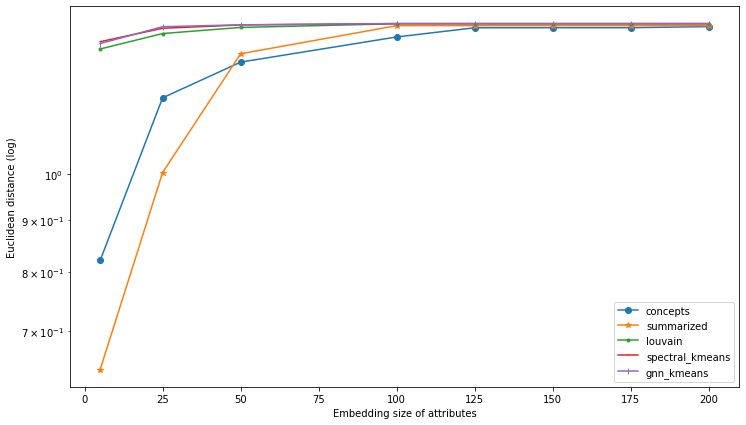

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
markers = ['o', '*', '.', ',', '|']
for i, method in enumerate(['concepts', 'summarized', 'louvain', 'spectral_kmeans', 'gnn_kmeans']):
    plt.plot(ks, avgs.get(method), label=method, marker=markers[i])
plt.yscale('log')
plt.xlabel('Embedding size of attributes')
plt.ylabel('Euclidean distance (log)')
plt.legend();

#### Word2Vec + Wasserstein distance on word embeddings $\rightarrow$ Word Moving Distance (WMD)

##### Build word embeddings

Each Wikipedia article is considered as a sentence. Each word from each sentence is embedded in latent space.

In [114]:
import gensim
import gensim.models
import gensim.downloader as api

In [1187]:
class MyCorpus():
    """A memory-friendly iterator that yields sentences (lists of str)."""
    
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
    
    def __iter__(self):
        for line in self.data:
            #indices = np.flatnonzero(line)
            w = self.vocab[line.indices]
            yield list(w)

In [1188]:
#sentences = MyCorpus(concept_attributes, words)
sentences = MyCorpus(biadjacency, words)
mymodel = gensim.models.Word2Vec(sentences=sentences, min_count=1)

In [1174]:
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [1185]:
%%time

# Concepts
n = concept_attributes.shape[0]
wd_matrix_concepts = np.zeros((n, n))

for i in range(n):
    ind1 = np.flatnonzero(concept_attributes[i, :])
    w1 = words[ind1]
    for j in range(n):
        ind2 = np.flatnonzero(concept_attributes[j, :])
        w2 = words[ind2]
        wd_matrix_concepts[i, j] = model.wmdistance(w1, w2)

CPU times: user 20.9 s, sys: 1.95 s, total: 22.9 s
Wall time: 25 s


In [1207]:
values = wd_matrix_concepts.ravel()
filt_values = values[values != np.inf]
print(np.mean(filt_values))

1.3446797792315972


In [ ]:
1 + 1

In [ ]:
# Louvain
nb_louvain = len(np.unique(labels_louvain))
wd_matrix_louvain = np.zeros((nb_louvain, nb_louvain))

for i in range(nb_louvain):
    ind1 = np.flatnonzero(concept_louvain_attributes[i, :])
    w1 = words[ind1]
    for j in range(nb_louvain):
        ind2 = np.flatnonzero(concept_louvain_attributes[j, :])
        w2 = words[ind2]
        wd_matrix_louvain[i, j] = model.wmdistance(w1, w2)

In [ ]:
values = wd_matrix_louvain.ravel()
filt_values = values[values != np.inf]
print(np.mean(filt_values))

##### Doc2Vec + Wasserstein distance

Instead of computing average of $\texttt{Word2Vec}$ word embeddings to build Document embedding, we use $\texttt{Doc2Vec}$ (see [documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html)).  

> The basic idea is: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector.

In [178]:
class MyCorpus():
    """A memory-friendly iterator that yields documents as TaggedDocument objects, i.e tokens associated with index of document."""
    
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
    
    def __iter__(self):
        if isinstance(self.data, sparse.csr_matrix):
            for i, x in enumerate(self.data):
                tokens = list(self.vocab[x.indices])
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        else:
            for i, x in enumerate(self.data):
                tokens = list(self.vocab[np.flatnonzero(x)])
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [153]:
# Doc2Vec model 
corpus = list(MyCorpus(concept_attributes, sorted_names_col))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=40)
model.build_vocab(corpus)

In [157]:
print(f"Word 'cmyk' appeared {model.wv.get_vecattr('cmyk', 'count')} times in the training corpus.")

Word 'cmyk' appeared 1 times in the training corpus.


In [158]:
# Training model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [169]:
# Use Wasserstein distance to compute (di)similarity between pairs of documents/concepts/communities embeddings
nb_concepts = len(result) - 1
d2v_wd_matrix_concepts = np.zeros((nb_concepts, nb_concepts))

for i in range(nb_concepts):
    w1 = sorted_names_col[result[i + 1][1]]
    for j in range(nb_concepts):
        w2 = sorted_names_col[result[j + 1][1]]
        d2v_wd_matrix_concepts[i, j] = wasserstein_distance(model.infer_vector(w1), model.infer_vector(w2))

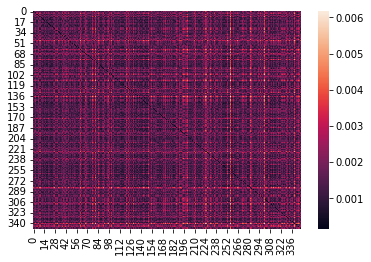

In [172]:
sns.heatmap(d2v_wd_matrix_concepts);

In [180]:
np.mean(d2v_wd_matrix_concepts)

0.001680542443469808

In [ ]:
%%time
# Louvain

# Doc2Vec model 
corpus = list(MyCorpus(concept_louvain_attributes, words))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=40)
model.build_vocab(corpus)

# Train model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

# Use Wasserstein distance to compute (di)similarity between pairs of documents/concepts/communities embeddings
nb_comm = len(np.unique(labels_louvain))
d2v_wd_matrix_louvain = np.zeros((nb_comm, nb_comm))

for i in range(nb_comm):
    w1 = words[np.flatnonzero(concept_louvain_attributes[i, :])]
    for j in range(nb_comm):
        w2 = words[np.flatnonzero(concept_louvain_attributes[j, :])]
        d2v_wd_matrix_louvain[i, j] = wasserstein_distance(model.infer_vector(w1), model.infer_vector(w2))

In [ ]:
np.mean(d2v_wd_matrix_louvain)

### Some concepts

['Dolly' 'hello' 'singer']


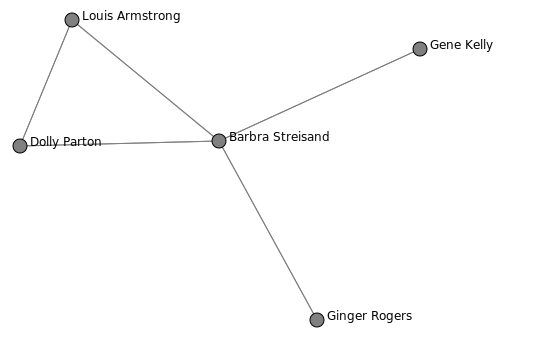

In [298]:
# First graph
objs = np.array([2471, 5418, 3436, 3543,  893])
attrs = np.array([3232, 4409, 16476])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['monazite' 'earth']


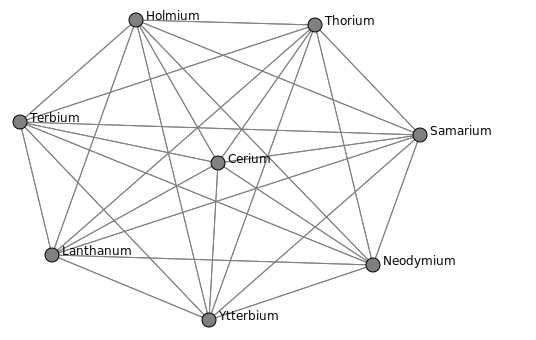

In [299]:
objs = np.array([9094, 4166, 1576, 6317, 9938, 8921, 7900, 5183])
attrs = np.array([5429, 17017])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['Anschluss' 'Hitler']


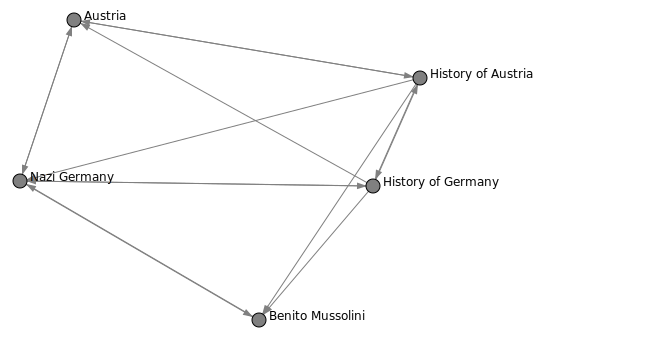

In [347]:
objs = np.array([777, 4078, 1010, 6298, 4063])
attrs = np.array([103, 14319])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

### Random concept

[7745 8098 7500 5360 9427] [ 4458 15323 17130 17803 18016]
['Laureus' 'medal' 'gold' 'final' 'title']


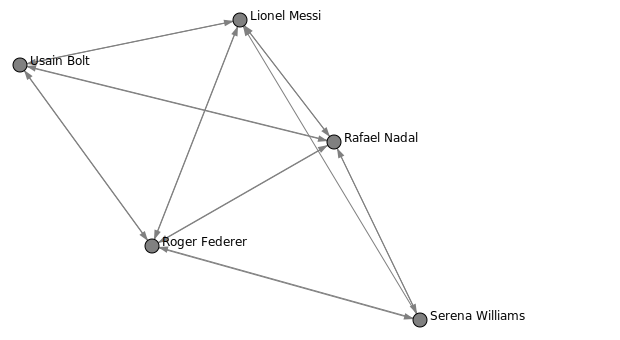

In [387]:
rand_idx = np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

In [388]:
{i: n for i, n in enumerate(names) if 'Rafael Nadal' in n}

{7500: 'Rafael Nadal'}

**All concepts related to one specific node**

In [401]:
for c in result:
    if 7500 in c[0]:
        print(f'{str(c[1]):>35} - {str(c[0])}')

                                 [] - [    0     1     2 ... 10008 10009 10010]
                        [3983 8801] - [7745 8578 5700 8740 7500 8914 5652]
                   [3983 7224 8801] - [7745 8578 8740 7500 8914 5652]
          [ 4458 15323 17130 18107] - [7745 8098 7500 5360 6224 2675 9427]
                [ 4458 15323 15536] - [8098 7500 5360 6224 2675 9427]
          [ 4458 15323 15536 15796] - [8098 7500 5360 2675 9427]
          [ 4458 15323 15796 17130] - [7745 8098 7500 5360 2675 9427]
          [ 4458 15323 15796 16007] - [7745 8098 7500 5360 9427]
                [ 4458 15323 16007] - [7745 8098 7500 5360 9427]
    [ 4458 15323 17130 17803 18107] - [7745 8098 7500 5360 2675 9427]
    [ 4458 15323 17130 17803 18016] - [7745 8098 7500 5360 9427]
          [ 4458 15323 17130 18004] - [7745 8098 7500 5360 6224]


In [409]:
for c in result:
    if 7500 in c[0]:
        print(f'{str(sorted_names_col[c[1]]):<40}')#' - {names[c[0]]}')

[]                                      
['Wimbledon' 'Slam']                    
['Wimbledon' 'Tennis' 'Slam']           
['Laureus' 'medal' 'gold' 'win']        
['Laureus' 'medal' 'olympic']           
['Laureus' 'medal' 'olympic' 'consecutive']
['Laureus' 'medal' 'consecutive' 'gold']
['Laureus' 'medal' 'consecutive' 'Year']
['Laureus' 'medal' 'Year']              
['Laureus' 'medal' 'gold' 'final' 'win']
['Laureus' 'medal' 'gold' 'final' 'title']
['Laureus' 'medal' 'gold' 'career']     


['Laureus' 'medal' 'Year']


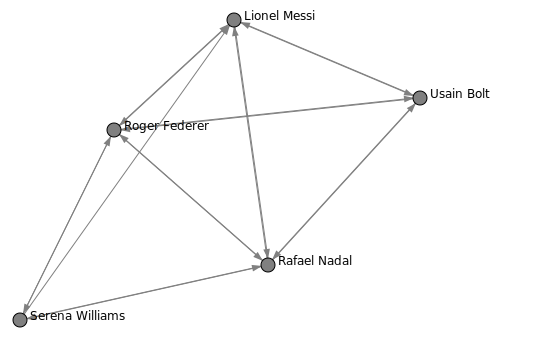

In [414]:
objs = np.array([7745, 8098, 7500, 5360, 9427])
attrs = np.array([4458, 15323, 16007])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['Wimbledon' 'Slam']


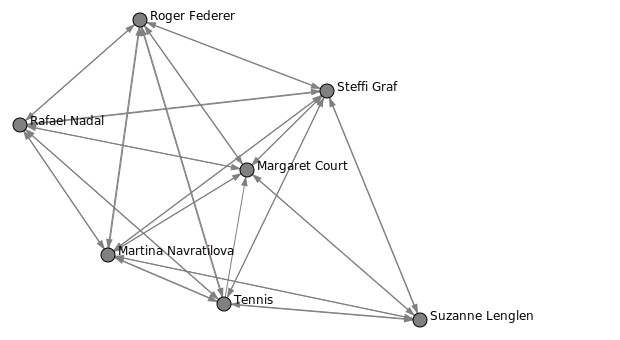

In [411]:
objs = np.array([7745, 8578, 5700, 8740, 7500, 8914, 5652])
attrs = np.array([3983, 8801])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

## Quantitative analysis

**Nodes and attributes size distributions in concepts**

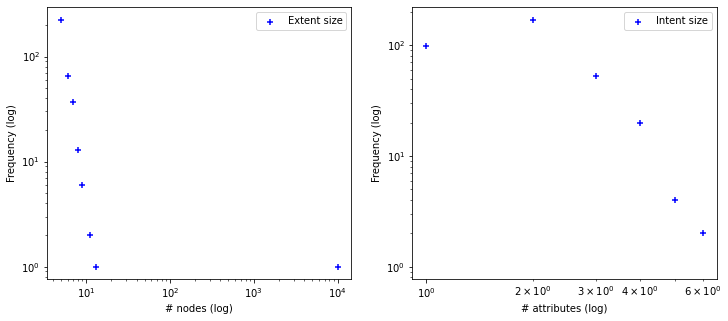

In [334]:
nodes_list, attrs_list = zip(*result)

len_n = map(len, nodes_list)
len_a = map(len, attrs_list)

fig, ax = plt.subplots(1, 2, figsize=(12, 5),)
plot_distrib(Counter(len_n), ax[0], label='Extent size', xlabel='# nodes')
plot_distrib(Counter(len_a), ax[1], label='Intent size', xlabel='# attributes')

### Number of concepts per object

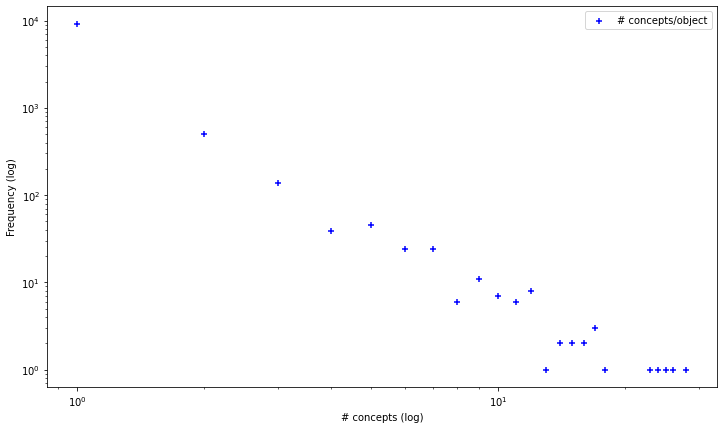

In [418]:
object_concepts = np.zeros(adjacency.shape[0])

for i in range(adjacency.shape[0]):
    for c in result:
        if i in c[0]:
            object_concepts[i] += 1
            
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib(object_concepts, ax=ax, label='# concepts/object', xlabel='# concepts')

The majority of objects appear in only 1 concept, but a few objects appear in more than 10 concepts.

In [432]:
# Objects that appear in lots of concepts
for i in np.argsort(-object_concepts)[:10]:
    print(f'Article: {(names[i]):>20} - # of related concepts: {object_concepts[i]}')

Article:  Kareem Abdul-Jabbar - # of related concepts: 28.0
Article:         Lionel Messi - # of related concepts: 26.0
Article:        Magic Johnson - # of related concepts: 25.0
Article:     Wilt Chamberlain - # of related concepts: 24.0
Article:       Michael Jordan - # of related concepts: 23.0
Article:              Eusébio - # of related concepts: 18.0
Article:         LeBron James - # of related concepts: 17.0
Article:    Cristiano Ronaldo - # of related concepts: 17.0
Article:   Alfredo Di Stéfano - # of related concepts: 17.0
Article:        Elvis Presley - # of related concepts: 16.0


In [436]:
# Objects that appear in lots of concepts
for i in np.argsort(-object_concepts)[-10:]:
    print(f'Article: {(names[i]):>30} - # of related concepts: {object_concepts[i]}')

Article:                  Geochronology - # of related concepts: 1.0
Article:                        Geodesy - # of related concepts: 1.0
Article:                 Geodetic datum - # of related concepts: 1.0
Article:               Geoffrey Chaucer - # of related concepts: 1.0
Article:           Geoffrey of Monmouth - # of related concepts: 1.0
Article:   Geographic coordinate system - # of related concepts: 1.0
Article:                      Geography - # of related concepts: 1.0
Article:                          Geoid - # of related concepts: 1.0
Article:    Geological history of Earth - # of related concepts: 1.0
Article:                             −1 - # of related concepts: 1.0


## Annexes
---

In [ ]:
def build_random_graph(n, p):
    edges = []
    lp = np.log(1 - p)
    v = 1
    w = -1
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((w, v))
    
    v = 1
    w = -1   
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((v, w))
    try:
        g = from_edge_list(edges, directed=True, matrix_only=True)
    except ValueError:
        return None

    return g